In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
sns.set_palette('husl')

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 1. Data Loading

In [24]:
# Define file paths
results_dir = Path('../results')

# Load all files
files = {
    'Ambiance_BERT': 'Ambiance_sentiment_bert_base_cased.csv',
    'Ambiance_TinyRoBERTa': 'Ambiance_sentiment_tinyroberta_squad2.csv',
    'Food_BERT': 'Food_sentiment_bert_base_cased.csv',
    'Food_TinyRoBERTa': 'Food_sentiment_tinyroberta_squad2.csv',
    'Service_BERT': 'Service_sentiment_bert_base_cased.csv',
    'Service_TinyRoBERTa': 'Service_sentiment_tinyroberta_squad2.csv'
}

data = {}
for key, filename in files.items():
    filepath = results_dir / filename
    data[key] = pd.read_csv(filepath)
    print(f"✅ {key}: {len(data[key])} rows")

print(f"\nTotal datasets loaded: {len(data)}")

✅ Ambiance_BERT: 25004 rows
✅ Ambiance_TinyRoBERTa: 21667 rows
✅ Food_BERT: 25004 rows
✅ Food_TinyRoBERTa: 21683 rows
✅ Service_BERT: 25004 rows
✅ Service_TinyRoBERTa: 21667 rows

Total datasets loaded: 6


## 2. Data Structure Analysis

In [25]:
# Check BERT model data structure
print("=== BERT Model Data Structure ===")
print("\nFood_BERT columns:")
print(data['Food_BERT'].columns.tolist())
print("\nFirst 3 rows:")
print(data['Food_BERT'].head(3))

print("\n" + "="*60)

# Check TinyRoBERTa model data structure
print("\n=== TinyRoBERTa Model Data Structure ===")
print("\nService_TinyRoBERTa columns:")
print(data['Service_TinyRoBERTa'].columns.tolist())
print("\nFirst 3 rows:")
print(data['Service_TinyRoBERTa'].head(3))

=== BERT Model Data Structure ===

Food_BERT columns:
['review', 'restaurant_id', 'city', 'question', 'answer', 'confidence', 'cosine_sim', 'sentiment']

First 3 rows:
                                              review    restaurant_id   city  \
0  the french fry wasn t fresh the taste profile ...  Restaurant 1544  Dhaka   
1                           taste ratings out of yep  Restaurant 3815  Dhaka   
2                        taste quality ager moto nai  Restaurant 3489  Dhaka   

       question             answer  confidence  cosine_sim  sentiment  
0  Taste_Aspect  the taste profile    0.171494    0.849548   0.436155  
1  Taste_Aspect      taste ratings    0.411582    0.830429   0.231641  
2  Taste_Aspect      taste quality    0.653633    0.830022   0.351010  


=== TinyRoBERTa Model Data Structure ===

Service_TinyRoBERTa columns:
['text', 'name', 'city', 'Food_Aspect_Answer', 'Food_Aspect_Similarity_Score', 'Service_Aspect_Answer', 'Service_Aspect_Similarity_Score', 'Ambiance_A

## 3. Data Preprocessing and Standardization

In [26]:
# Standardize data format
def standardize_data(df, dataset_name, model_name):
    """Unify data format from different models"""
    df_std = pd.DataFrame()
    
    # Extract fields based on model type
    if 'BERT' in model_name:
        df_std['text'] = df['review'] if 'review' in df.columns else df.get('text', '')
        df_std['restaurant_id'] = df.get('restaurant_id', df.get('name', ''))
        df_std['city'] = df.get('city', '')
        df_std['sentiment'] = df.get('sentiment', 0)
        df_std['confidence'] = df.get('confidence', 0)
    else:  # TinyRoBERTa
        df_std['text'] = df.get('text', '')
        df_std['restaurant_id'] = df.get('name', df.get('restaurant_id', ''))
        df_std['city'] = df.get('city', '')
        df_std['sentiment_label'] = df.get('Sentiment_Label', '')
        df_std['confidence'] = df.get('Sentiment_Confidence', 0)
        
        # Convert star rating to numeric value
        if 'sentiment_label' in df_std.columns:
            df_std['sentiment'] = df_std['sentiment_label'].str.extract('(\d+)').astype(float) / 5.0
    
    df_std['dataset'] = dataset_name
    df_std['model'] = model_name
    df_std['text_length'] = df_std['text'].astype(str).apply(len)
    df_std['word_count'] = df_std['text'].astype(str).apply(lambda x: len(x.split()))
    
    return df_std

# Process all datasets
processed_data = {}
for key, df in data.items():
    dataset_name, model_name = key.split('_', 1)
    processed_data[key] = standardize_data(df, dataset_name, model_name)
    print(f"✅ Processed: {key}")

# Merge all data
all_data = pd.concat(processed_data.values(), ignore_index=True)
print(f"\n✅ Merge complete, total records: {len(all_data)}")

✅ Processed: Ambiance_BERT
✅ Processed: Ambiance_TinyRoBERTa
✅ Processed: Food_BERT
✅ Processed: Food_TinyRoBERTa
✅ Processed: Service_BERT
✅ Processed: Service_TinyRoBERTa

✅ Merge complete, total records: 140029
✅ Processed: Food_TinyRoBERTa
✅ Processed: Service_BERT
✅ Processed: Service_TinyRoBERTa

✅ Merge complete, total records: 140029


## 4. Dataset Size Comparison

=== Dataset Size Comparison ===
model      BERT  TinyRoBERTa
dataset                     
Ambiance  25004        21667
Food      25004        21683
Service   25004        21667


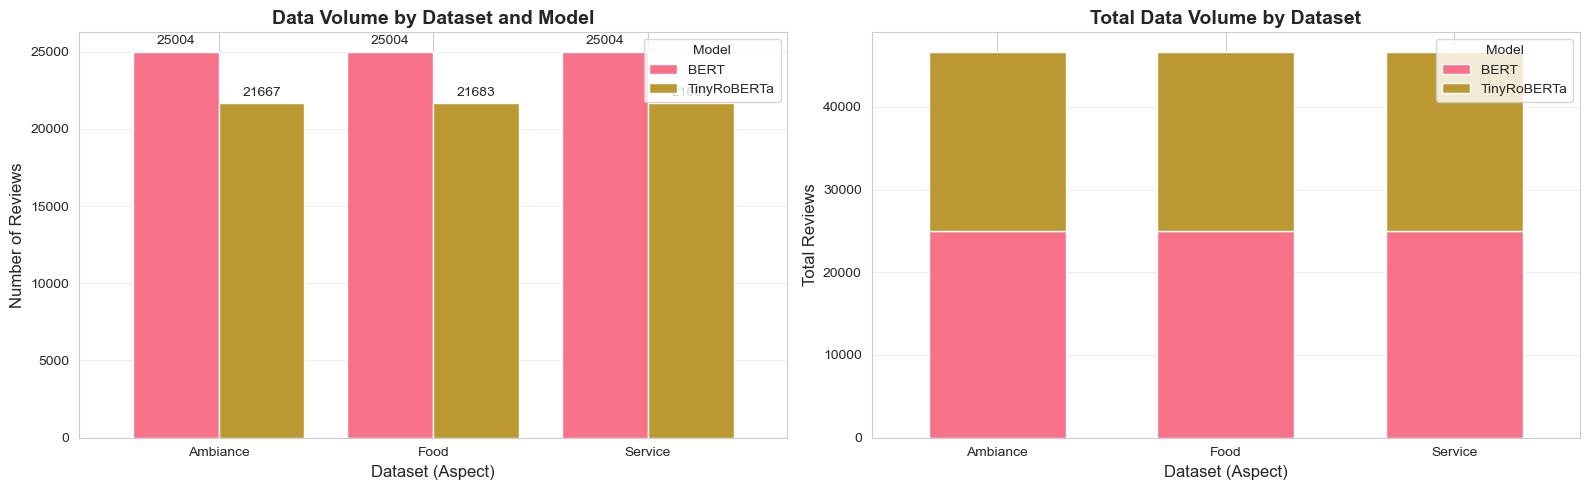


Total reviews: 140,029

By dataset:
dataset
Food        46687
Ambiance    46671
Service     46671
Name: count, dtype: int64

By model:
model
BERT           75012
TinyRoBERTa    65017
Name: count, dtype: int64


In [27]:
# Calculate size of each dataset
dataset_sizes = all_data.groupby(['dataset', 'model']).size().reset_index(name='count')
dataset_sizes_pivot = dataset_sizes.pivot(index='dataset', columns='model', values='count')

print("=== Dataset Size Comparison ===")
print(dataset_sizes_pivot)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Subplot 1: Grouped bar chart
dataset_sizes_pivot.plot(kind='bar', ax=axes[0], width=0.8)
axes[0].set_title('Data Volume by Dataset and Model', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Dataset (Aspect)', fontsize=12)
axes[0].set_ylabel('Number of Reviews', fontsize=12)
axes[0].legend(title='Model', loc='upper right')
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=0)

# Add value labels
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d', padding=3)

# Subplot 2: Stacked bar chart
dataset_sizes_pivot.plot(kind='bar', stacked=True, ax=axes[1], width=0.6)
axes[1].set_title('Total Data Volume by Dataset', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Dataset (Aspect)', fontsize=12)
axes[1].set_ylabel('Total Reviews', fontsize=12)
axes[1].legend(title='Model', loc='upper right')
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# Overall statistics
print(f"\nTotal reviews: {len(all_data):,}")
print(f"\nBy dataset:")
print(all_data['dataset'].value_counts())
print(f"\nBy model:")
print(all_data['model'].value_counts())

## 5. Sentiment Distribution Analysis

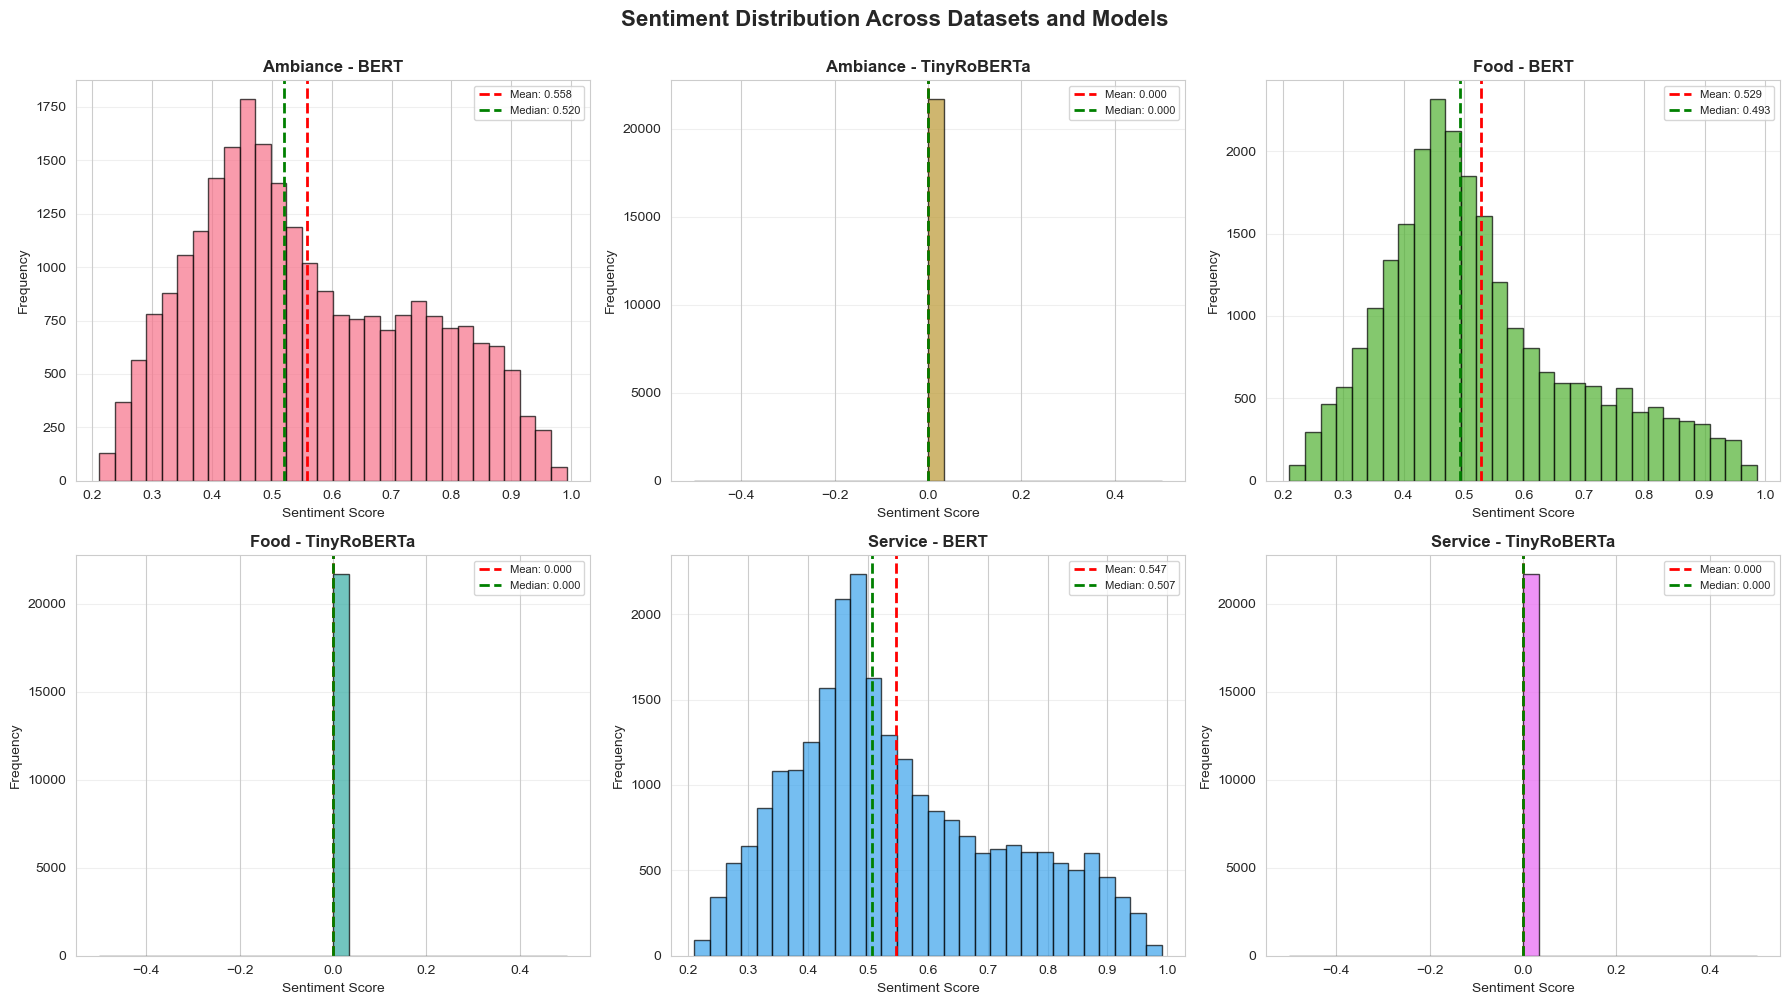

In [28]:
# Sentiment distribution analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

datasets = ['Ambiance', 'Food', 'Service']
models = ['BERT', 'TinyRoBERTa']

plot_idx = 0
for dataset in datasets:
    for model in models:
        df_subset = all_data[(all_data['dataset'] == dataset) & (all_data['model'] == model)]
        
        ax = axes[plot_idx]
        
        # Plot sentiment distribution histogram
        ax.hist(df_subset['sentiment'], bins=30, edgecolor='black', alpha=0.7, color=sns.color_palette()[plot_idx])
        ax.set_title(f'{dataset} - {model}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Sentiment Score', fontsize=10)
        ax.set_ylabel('Frequency', fontsize=10)
        ax.grid(axis='y', alpha=0.3)
        
        # Add statistical information
        mean_val = df_subset['sentiment'].mean()
        median_val = df_subset['sentiment'].median()
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.3f}')
        ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.3f}')
        ax.legend(fontsize=8)
        
        plot_idx += 1

plt.suptitle('Sentiment Distribution Across Datasets and Models', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 6. Sentiment Statistics Comparison

=== Sentiment Statistics ===
                        Mean  Median     Std     Min     Max      Q1      Q3
dataset  model                                                              
Ambiance BERT         0.5582  0.5204  0.1824  0.2121  0.9925  0.4182  0.7051
         TinyRoBERTa  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
Food     BERT         0.5289  0.4935  0.1621  0.2104  0.9865  0.4184  0.6154
         TinyRoBERTa  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
Service  BERT         0.5474  0.5074  0.1742  0.2104  0.9904  0.4247  0.6639
         TinyRoBERTa  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000


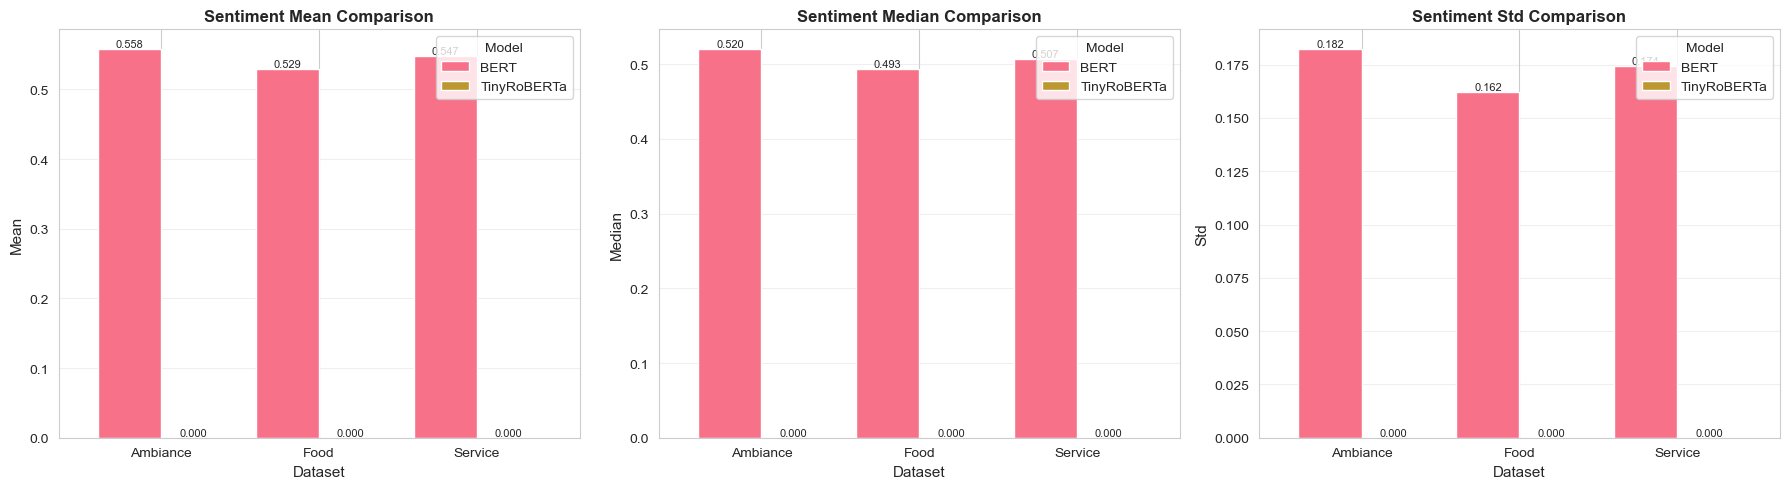

In [29]:
# Calculate statistical metrics
sentiment_stats = all_data.groupby(['dataset', 'model'])['sentiment'].agg([
    ('Mean', 'mean'),
    ('Median', 'median'),
    ('Std', 'std'),
    ('Min', 'min'),
    ('Max', 'max'),
    ('Q1', lambda x: x.quantile(0.25)),
    ('Q3', lambda x: x.quantile(0.75))
]).round(4)

print("=== Sentiment Statistics ===")
print(sentiment_stats)

# Visualization comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['Mean', 'Median', 'Std']
for idx, metric in enumerate(metrics):
    sentiment_stats[metric].unstack().plot(kind='bar', ax=axes[idx], width=0.8)
    axes[idx].set_title(f'Sentiment {metric} Comparison', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Dataset', fontsize=11)
    axes[idx].set_ylabel(metric, fontsize=11)
    axes[idx].legend(title='Model', loc='best')
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=0)
    
    # Add value labels
    for container in axes[idx].containers:
        axes[idx].bar_label(container, fmt='%.3f', fontsize=8)

plt.tight_layout()
plt.show()

## 7. Box Plot Comparison - Identify Outliers

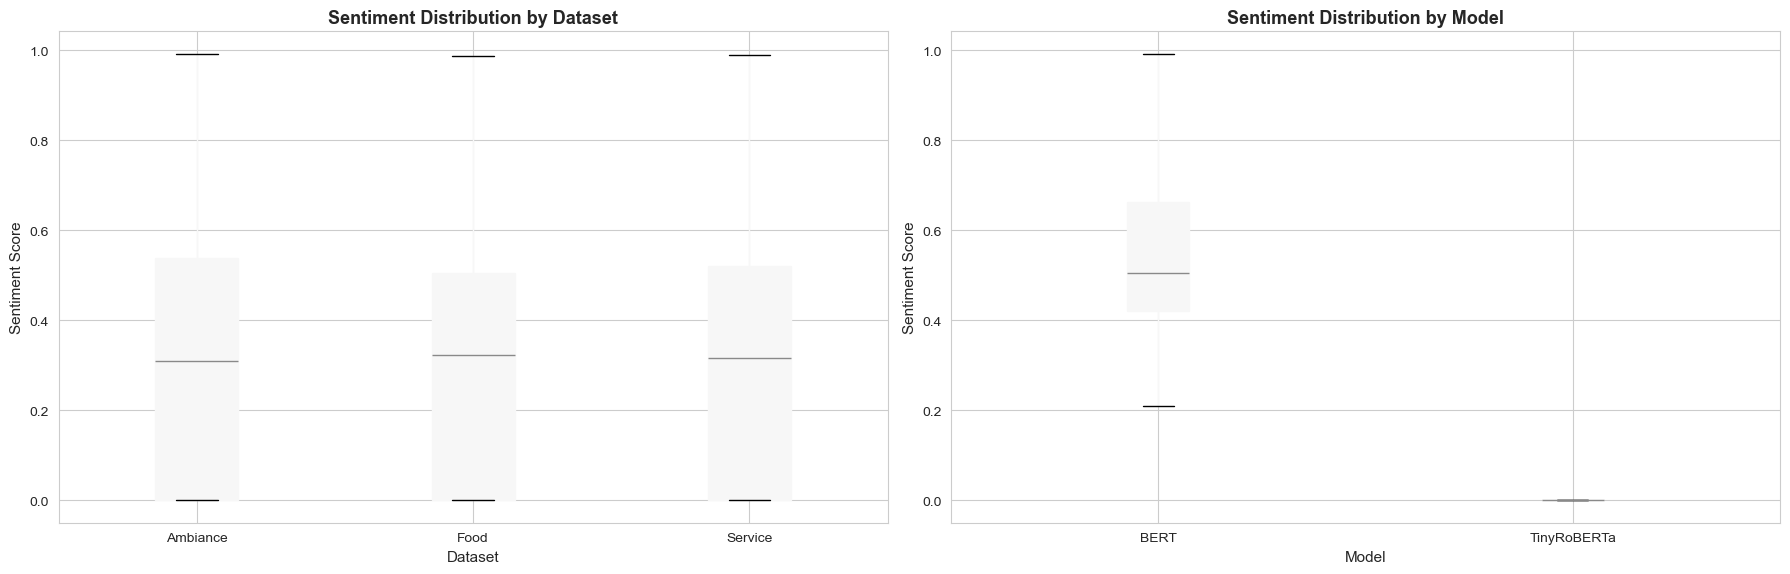

<Figure size 1400x600 with 0 Axes>

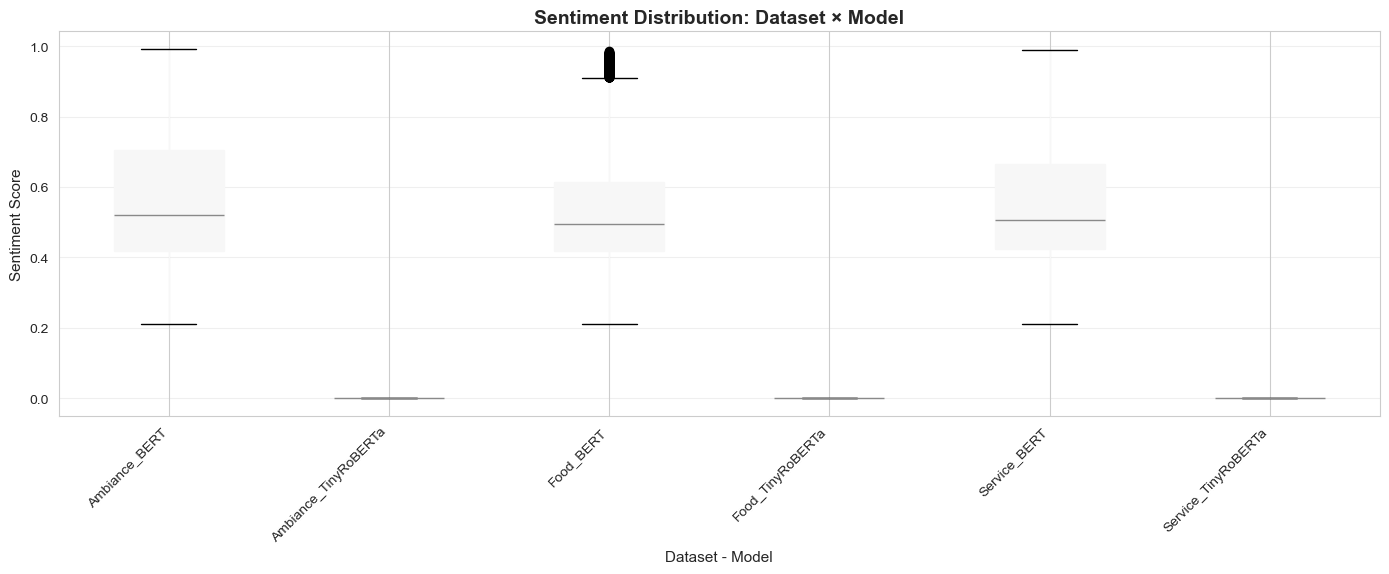

In [30]:
# Box plot comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Group by dataset
all_data.boxplot(column='sentiment', by='dataset', ax=axes[0], patch_artist=True)
axes[0].set_title('Sentiment Distribution by Dataset', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Dataset', fontsize=11)
axes[0].set_ylabel('Sentiment Score', fontsize=11)
axes[0].get_figure().suptitle('')

# Group by model
all_data.boxplot(column='sentiment', by='model', ax=axes[1], patch_artist=True)
axes[1].set_title('Sentiment Distribution by Model', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Model', fontsize=11)
axes[1].set_ylabel('Sentiment Score', fontsize=11)
axes[1].get_figure().suptitle('')

plt.tight_layout()
plt.show()

# Detailed box plot - Dataset and model combinations
plt.figure(figsize=(14, 6))
all_data['dataset_model'] = all_data['dataset'] + '_' + all_data['model']
all_data.boxplot(column='sentiment', by='dataset_model', figsize=(14, 6), patch_artist=True)
plt.title('Sentiment Distribution: Dataset × Model', fontsize=14, fontweight='bold')
plt.xlabel('Dataset - Model', fontsize=11)
plt.ylabel('Sentiment Score', fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.suptitle('')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Confidence Score Analysis

=== Confidence Statistics ===
                        Mean  Median     Std  Min     Max
dataset  model                                           
Ambiance BERT         0.1384  0.0386  0.2020  0.0  0.9937
         TinyRoBERTa  0.0000  0.0000  0.0000  0.0  0.0000
Food     BERT         0.2582  0.2053  0.2180  0.0  0.9789
         TinyRoBERTa  0.0000  0.0000  0.0000  0.0  0.0000
Service  BERT         0.1260  0.0673  0.1487  0.0  0.9479
         TinyRoBERTa  0.0000  0.0000  0.0000  0.0  0.0000


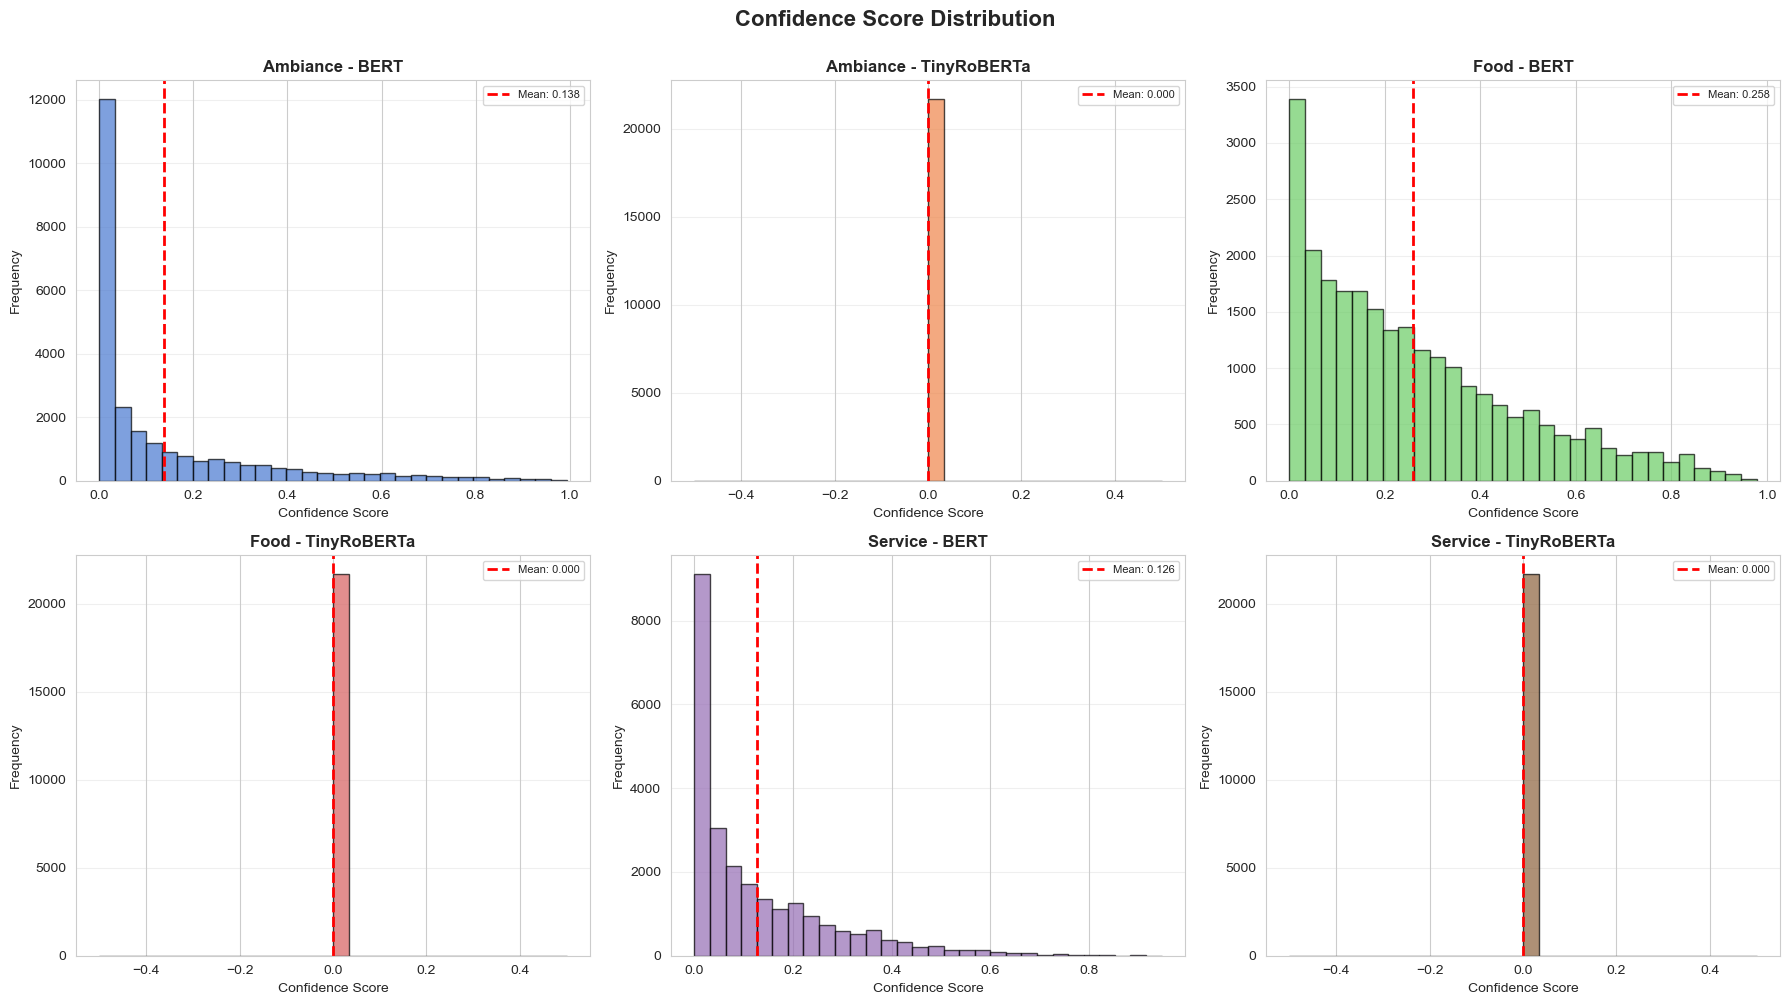

In [31]:
# Confidence statistics
confidence_stats = all_data.groupby(['dataset', 'model'])['confidence'].agg([
    ('Mean', 'mean'),
    ('Median', 'median'),
    ('Std', 'std'),
    ('Min', 'min'),
    ('Max', 'max')
]).round(4)

print("=== Confidence Statistics ===")
print(confidence_stats)

# Visualize confidence distribution
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

plot_idx = 0
for dataset in datasets:
    for model in models:
        df_subset = all_data[(all_data['dataset'] == dataset) & (all_data['model'] == model)]
        
        ax = axes[plot_idx]
        ax.hist(df_subset['confidence'], bins=30, edgecolor='black', alpha=0.7, color=sns.color_palette('muted')[plot_idx])
        ax.set_title(f'{dataset} - {model}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Confidence Score', fontsize=10)
        ax.set_ylabel('Frequency', fontsize=10)
        ax.grid(axis='y', alpha=0.3)
        
        mean_conf = df_subset['confidence'].mean()
        ax.axvline(mean_conf, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_conf:.3f}')
        ax.legend(fontsize=8)
        
        plot_idx += 1

plt.suptitle('Confidence Score Distribution', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 9. Confidence Score Comparison

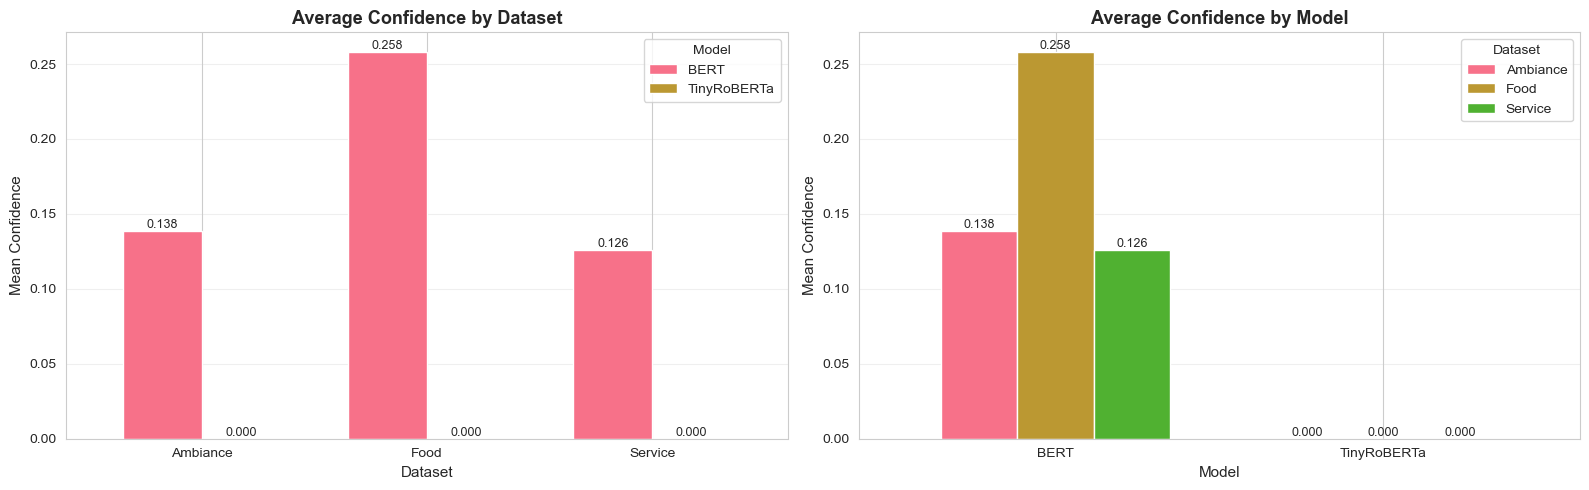

In [32]:
# Average confidence comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Compare by dataset
confidence_by_dataset = all_data.groupby(['dataset', 'model'])['confidence'].mean().unstack()
confidence_by_dataset.plot(kind='bar', ax=axes[0], width=0.7)
axes[0].set_title('Average Confidence by Dataset', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Dataset', fontsize=11)
axes[0].set_ylabel('Mean Confidence', fontsize=11)
axes[0].legend(title='Model')
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=0)

for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.3f', fontsize=9)

# Compare by model
confidence_by_model = all_data.groupby(['model', 'dataset'])['confidence'].mean().unstack()
confidence_by_model.plot(kind='bar', ax=axes[1], width=0.7)
axes[1].set_title('Average Confidence by Model', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Model', fontsize=11)
axes[1].set_ylabel('Mean Confidence', fontsize=11)
axes[1].legend(title='Dataset')
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=0)

for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.3f', fontsize=9)

plt.tight_layout()
plt.show()

## 10. Sentiment vs Confidence Scatter Plot

 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


LinAlgError: SVD did not converge in Linear Least Squares

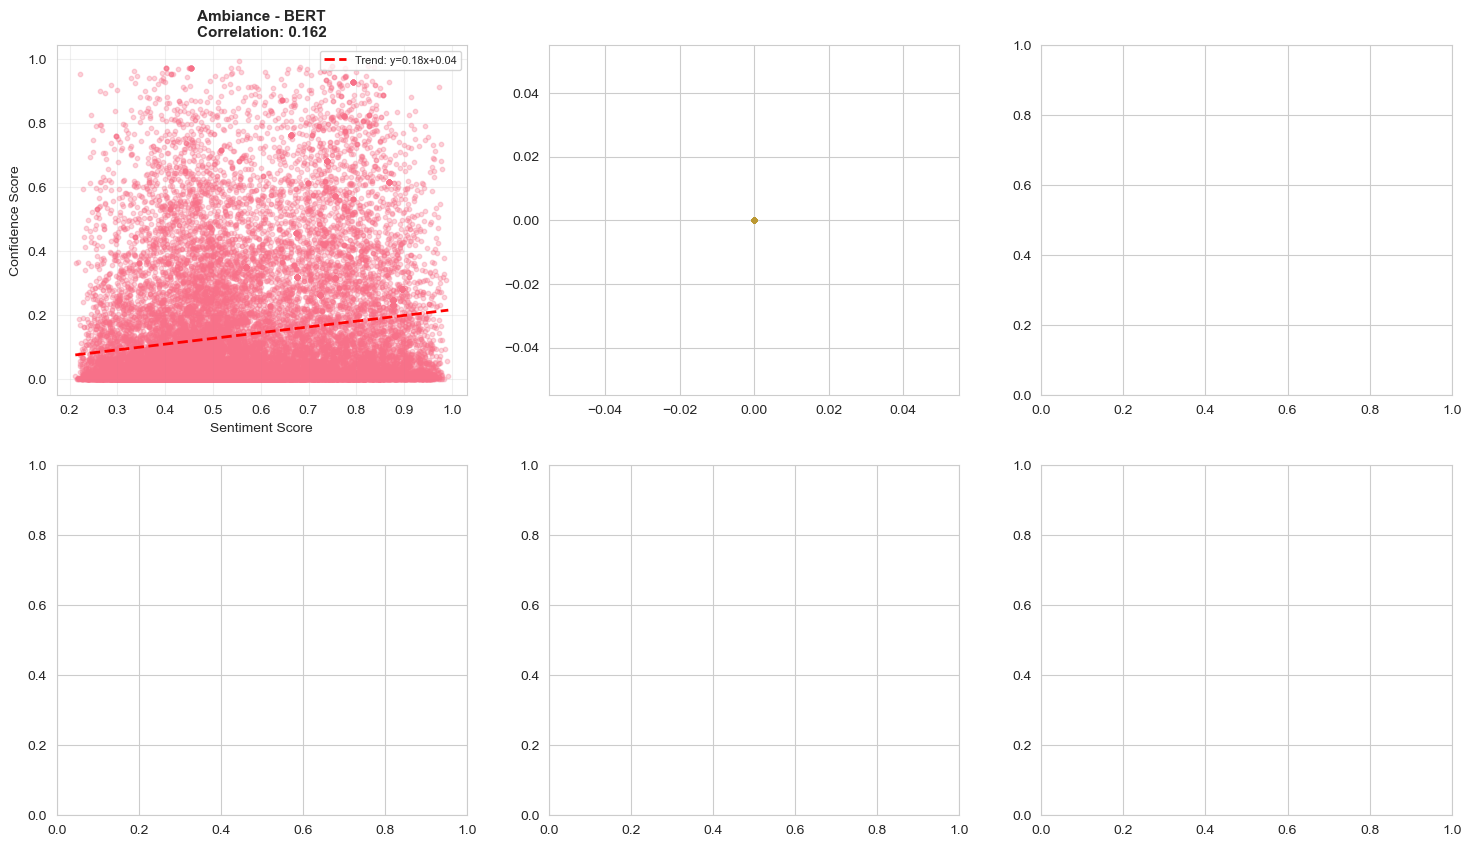

In [33]:
# Relationship between sentiment and confidence
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

plot_idx = 0
for dataset in datasets:
    for model in models:
        df_subset = all_data[(all_data['dataset'] == dataset) & (all_data['model'] == model)]
        
        ax = axes[plot_idx]
        
        # Scatter plot + density
        scatter = ax.scatter(df_subset['sentiment'], df_subset['confidence'], 
                           alpha=0.3, s=10, c=sns.color_palette()[plot_idx])
        
        # Add trend line
        z = np.polyfit(df_subset['sentiment'], df_subset['confidence'], 1)
        p = np.poly1d(z)
        x_line = np.linspace(df_subset['sentiment'].min(), df_subset['sentiment'].max(), 100)
        ax.plot(x_line, p(x_line), 'r--', linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
        
        # Calculate correlation coefficient
        corr = df_subset[['sentiment', 'confidence']].corr().iloc[0, 1]
        
        ax.set_title(f'{dataset} - {model}\nCorrelation: {corr:.3f}', fontsize=11, fontweight='bold')
        ax.set_xlabel('Sentiment Score', fontsize=10)
        ax.set_ylabel('Confidence Score', fontsize=10)
        ax.legend(fontsize=8)
        ax.grid(alpha=0.3)
        
        plot_idx += 1

plt.suptitle('Sentiment vs Confidence: Correlation Analysis', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 11. Text Length Analysis

In [ ]:
# Text length statistics
text_stats = all_data.groupby(['dataset', 'model']).agg({
    'text_length': ['mean', 'median', 'std'],
    'word_count': ['mean', 'median', 'std']
}).round(2)

print("=== Text Length Statistics ===")
print(text_stats)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Character count comparison
text_length_mean = all_data.groupby(['dataset', 'model'])['text_length'].mean().unstack()
text_length_mean.plot(kind='bar', ax=axes[0, 0], width=0.7)
axes[0, 0].set_title('Average Text Length (Characters)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Dataset', fontsize=11)
axes[0, 0].set_ylabel('Characters', fontsize=11)
axes[0, 0].legend(title='Model')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=0)

for container in axes[0, 0].containers:
    axes[0, 0].bar_label(container, fmt='%.1f', fontsize=8)

# Word count comparison
word_count_mean = all_data.groupby(['dataset', 'model'])['word_count'].mean().unstack()
word_count_mean.plot(kind='bar', ax=axes[0, 1], width=0.7)
axes[0, 1].set_title('Average Word Count', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Dataset', fontsize=11)
axes[0, 1].set_ylabel('Words', fontsize=11)
axes[0, 1].legend(title='Model')
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=0)

for container in axes[0, 1].containers:
    axes[0, 1].bar_label(container, fmt='%.1f', fontsize=8)

# Text length distribution box plot
all_data.boxplot(column='word_count', by='dataset', ax=axes[1, 0])
axes[1, 0].set_title('Word Count Distribution by Dataset', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Dataset', fontsize=11)
axes[1, 0].set_ylabel('Word Count', fontsize=11)
axes[1, 0].get_figure().suptitle('')

# Box plot by model
all_data.boxplot(column='word_count', by='model', ax=axes[1, 1])
axes[1, 1].set_title('Word Count Distribution by Model', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Model', fontsize=11)
axes[1, 1].set_ylabel('Word Count', fontsize=11)
axes[1, 1].get_figure().suptitle('')

plt.tight_layout()
plt.show()

## 12. Text Length vs Sentiment/Confidence

In [ ]:
# Relationship between text length and sentiment/confidence
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Text length vs sentiment
for dataset in datasets:
    df_subset = all_data[all_data['dataset'] == dataset]
    axes[0].scatter(df_subset['word_count'], df_subset['sentiment'], alpha=0.3, s=5, label=dataset)

axes[0].set_title('Word Count vs Sentiment', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Word Count', fontsize=11)
axes[0].set_ylabel('Sentiment Score', fontsize=11)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Text length vs confidence
for dataset in datasets:
    df_subset = all_data[all_data['dataset'] == dataset]
    axes[1].scatter(df_subset['word_count'], df_subset['confidence'], alpha=0.3, s=5, label=dataset)

axes[1].set_title('Word Count vs Confidence', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Word Count', fontsize=11)
axes[1].set_ylabel('Confidence Score', fontsize=11)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate correlation coefficients
print("=== Correlation Analysis ===")
for dataset in datasets:
    df_subset = all_data[all_data['dataset'] == dataset]
    corr_sentiment = df_subset[['word_count', 'sentiment']].corr().iloc[0, 1]
    corr_confidence = df_subset[['word_count', 'confidence']].corr().iloc[0, 1]
    print(f"\n{dataset}:")
    print(f"  Word Count vs Sentiment: {corr_sentiment:.4f}")
    print(f"  Word Count vs Confidence: {corr_confidence:.4f}")

## 13. Model Comparison - Direct Comparison

In [ ]:
# Direct comparison of two models on same datasets
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, dataset in enumerate(datasets):
    bert_data = all_data[(all_data['dataset'] == dataset) & (all_data['model'] == 'BERT')]
    roberta_data = all_data[(all_data['dataset'] == dataset) & (all_data['model'] == 'TinyRoBERTa')]
    
    ax = axes[idx]
    
    # Sentiment distribution comparison
    ax.hist(bert_data['sentiment'], bins=30, alpha=0.5, label='BERT', color='blue', edgecolor='black')
    ax.hist(roberta_data['sentiment'], bins=30, alpha=0.5, label='TinyRoBERTa', color='orange', edgecolor='black')
    
    ax.set_title(f'{dataset} Dataset', fontsize=12, fontweight='bold')
    ax.set_xlabel('Sentiment Score', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Model Comparison: Sentiment Distribution Overlay', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 14. Heatmap - Comprehensive View

In [ ]:
# Create summary table
summary_metrics = all_data.groupby(['dataset', 'model']).agg({
    'sentiment': 'mean',
    'confidence': 'mean',
    'word_count': 'mean'
}).round(3)

# Heatmap
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['sentiment', 'confidence', 'word_count']
titles = ['Average Sentiment Score', 'Average Confidence Score', 'Average Word Count']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    pivot_data = summary_metrics[metric].unstack()
    sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='YlOrRd', ax=axes[idx], 
                cbar_kws={'label': metric}, linewidths=0.5)
    axes[idx].set_title(title, fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Model', fontsize=11)
    axes[idx].set_ylabel('Dataset', fontsize=11)

plt.tight_layout()
plt.show()

## 15. City Distribution Analysis (if city data available)

In [ ]:
# City data analysis
if 'city' in all_data.columns and all_data['city'].notna().sum() > 0:
    print("=== Top 10 Cities by Review Count ===")
    top_cities = all_data['city'].value_counts().head(10)
    print(top_cities)
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # City review count
    top_cities.plot(kind='barh', ax=axes[0], color='skyblue', edgecolor='black')
    axes[0].set_title('Top 10 Cities by Review Count', fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Number of Reviews', fontsize=11)
    axes[0].set_ylabel('City', fontsize=11)
    axes[0].grid(axis='x', alpha=0.3)
    
    # City sentiment average
    city_sentiment = all_data.groupby('city')['sentiment'].mean().sort_values(ascending=False).head(10)
    city_sentiment.plot(kind='barh', ax=axes[1], color='lightcoral', edgecolor='black')
    axes[1].set_title('Top 10 Cities by Average Sentiment', fontsize=13, fontweight='bold')
    axes[1].set_xlabel('Average Sentiment Score', fontsize=11)
    axes[1].set_ylabel('City', fontsize=11)
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("❌ No city data available")

## 16. Comprehensive Conclusion Summary

In [ ]:
print("="*80)
print("                         📊 COMPREHENSIVE ANALYSIS SUMMARY")
print("="*80)

print("\n1️⃣ DATA OVERVIEW")
print("-" * 80)
print(f"   Total Reviews Analyzed: {len(all_data):,}")
print(f"   Datasets: {', '.join(datasets)}")
print(f"   Models: {', '.join(models)}")

print("\n2️⃣ SENTIMENT ANALYSIS")
print("-" * 80)
sentiment_summary = all_data.groupby('dataset')['sentiment'].agg(['mean', 'std'])
for dataset in datasets:
    mean_val = sentiment_summary.loc[dataset, 'mean']
    std_val = sentiment_summary.loc[dataset, 'std']
    print(f"   {dataset:12s}: Mean = {mean_val:.4f}, Std = {std_val:.4f}")

print("\n3️⃣ MODEL PERFORMANCE")
print("-" * 80)
model_summary = all_data.groupby('model')['confidence'].agg(['mean', 'std'])
for model in models:
    mean_conf = model_summary.loc[model, 'mean']
    std_conf = model_summary.loc[model, 'std']
    print(f"   {model:15s}: Mean Confidence = {mean_conf:.4f}, Std = {std_conf:.4f}")

print("\n4️⃣ TEXT CHARACTERISTICS")
print("-" * 80)
text_summary = all_data.groupby('dataset')['word_count'].agg(['mean', 'median'])
for dataset in datasets:
    mean_words = text_summary.loc[dataset, 'mean']
    median_words = text_summary.loc[dataset, 'median']
    print(f"   {dataset:12s}: Mean = {mean_words:.1f} words, Median = {median_words:.1f} words")

print("\n5️⃣ KEY INSIGHTS")
print("-" * 80)

# Find datasets with highest and lowest sentiment
best_sentiment_dataset = all_data.groupby('dataset')['sentiment'].mean().idxmax()
worst_sentiment_dataset = all_data.groupby('dataset')['sentiment'].mean().idxmin()
print(f"   ✅ Highest Average Sentiment: {best_sentiment_dataset}")
print(f"   ⚠️  Lowest Average Sentiment: {worst_sentiment_dataset}")

# Find model with highest confidence
best_confidence_model = all_data.groupby('model')['confidence'].mean().idxmax()
print(f"   🎯 Highest Confidence Model: {best_confidence_model}")

# Data scale comparison
largest_dataset = all_data['dataset'].value_counts().idxmax()
largest_count = all_data['dataset'].value_counts().max()
print(f"   📈 Largest Dataset: {largest_dataset} ({largest_count:,} reviews)")

print("\n6️⃣ CORRELATIONS")
print("-" * 80)
overall_corr = all_data[['sentiment', 'confidence', 'word_count']].corr()
print(f"   Sentiment vs Confidence: {overall_corr.loc['sentiment', 'confidence']:.4f}")
print(f"   Sentiment vs Word Count: {overall_corr.loc['sentiment', 'word_count']:.4f}")
print(f"   Confidence vs Word Count: {overall_corr.loc['confidence', 'word_count']:.4f}")

print("\n" + "="*80)
print("                              ✨ ANALYSIS COMPLETE ✨")
print("="*80)

## 17. Export Analysis Results

In [ ]:
# Create comprehensive report CSV
output_dir = Path('../results')

# Summary statistics
summary_report = all_data.groupby(['dataset', 'model']).agg({
    'sentiment': ['count', 'mean', 'median', 'std', 'min', 'max'],
    'confidence': ['mean', 'median', 'std'],
    'word_count': ['mean', 'median', 'std']
}).round(4)

summary_report.to_csv(output_dir / 'comprehensive_analysis_summary.csv')
print("✅ Summary report saved to: comprehensive_analysis_summary.csv")

# Save merged data
all_data.to_csv(output_dir / 'all_data_combined.csv', index=False)
print("✅ Combined dataset saved to: all_data_combined.csv")

print("\n📁 All analysis files saved successfully!")